[Trains a memory network on the bAbI dataset.](https://keras.io/examples/babi_memnn/)

In [1]:
import tarfile, re
from functools import reduce

import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Embedding, Input, Activation, Dense, Permute, Dropout, LSTM,
    add, dot, concatenate
)
from tensorflow.keras.utils import get_file, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from matplotlib import pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
try:
    path = get_file('babi-tasks-v1-2.tar.gz',
                    origin='https://s3.amazonaws.com/text-datasets/'
                           'babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2'
          '.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise

In [4]:
challenges = {
    # QA1 with 10,000 samples
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_'
                                  'single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_'
                                'two-supporting-facts_{}.txt',
}
challenge_type = 'single_supporting_fact_10k'
challenge = challenges[challenge_type]

In [5]:
def tokenize(sent):
    return [x.strip() for x in re.split(r'(\W+)', sent) if x.strip()]

def parse_stories(lines, only_supporting=False):
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line: # question
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                supporting = map(int, supporting.split())
                substory = [story[i-1] for i in supporting]
            else:
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else: # story
            sent = tokenize(line)
            story.append(sent)
    return data

def get_stories(f, only_supporting=False, max_length=None):
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x,y: x+y, data)
    data = [(flatten(story), q, answer)
            for story, q, answer in data
            if not max_length or len(flatten(story)) < max_length]
    return data

In [6]:
with tarfile.open(path) as tar:
    train_stories = get_stories(tar.extractfile(challenge.format('train')))
    test_stories = get_stories(tar.extractfile(challenge.format('test')))
all_stories = train_stories + test_stories

In [7]:
vocab = set()
for story, q, answer in all_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

In [8]:
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in all_stories)))
query_maxlen = max(map(len, (x for _, x, _ in all_stories)))

In [9]:
train_stories[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'John',
  'went',
  'to',
  'the',
  'hallway',
  '.'],
 ['Where', 'is', 'Mary', '?'],
 'bathroom')

In [10]:
def vectorize_stories(data):
    inputs, queries, answers = [], [], []
    for story, query, answer in data:
        inputs.append([word_idx[w] for w in story])
        queries.append([word_idx[w] for w in query])
        answers.append(word_idx[answer])
    return (pad_sequences(inputs, maxlen=story_maxlen),
            pad_sequences(queries, maxlen=query_maxlen),
            np.array(answers))

In [11]:
word_idx = {c: i for i, c in enumerate(vocab, 1)}
inputs_train, queries_train, answers_train = vectorize_stories(train_stories)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories)

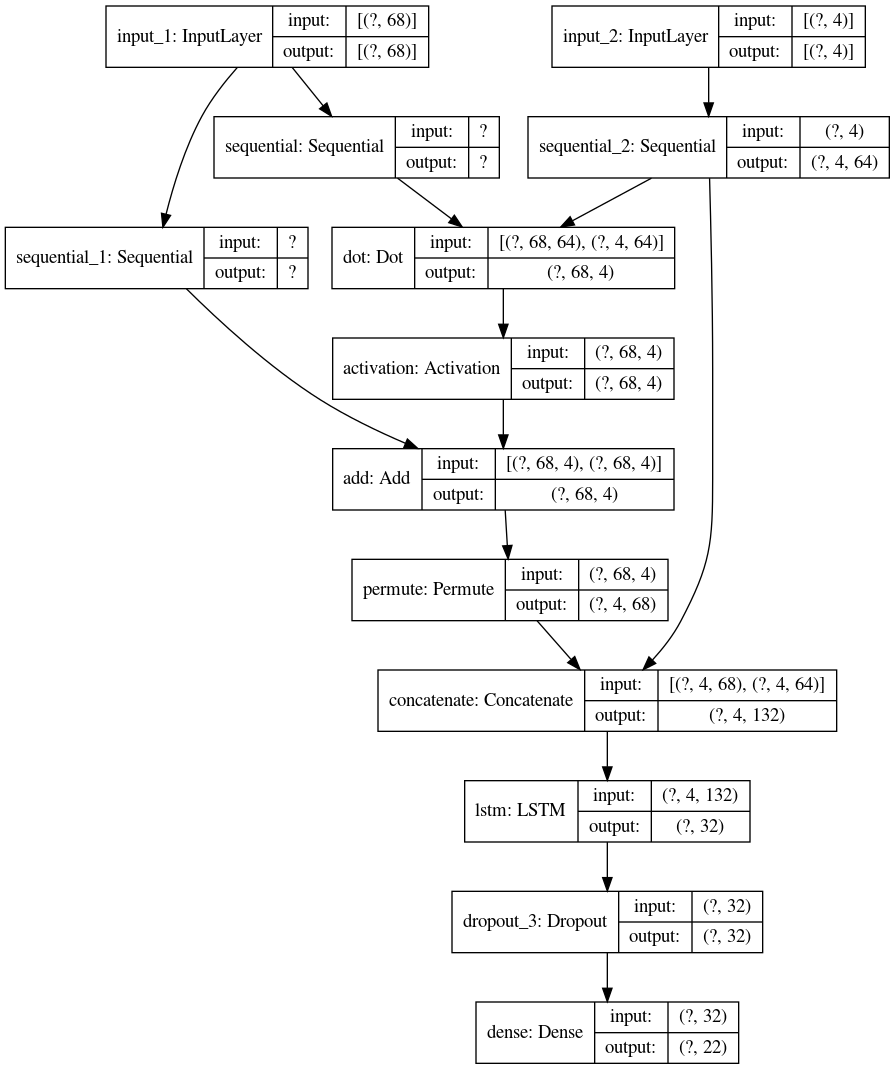

In [12]:
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

input_encoder_m = Sequential()
input_encoder_m.add(Embedding(vocab_size,64))
input_encoder_m.add(Dropout(0.3))

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(vocab_size,query_maxlen))
input_encoder_c.add(Dropout(0.3))

question_encoder = Sequential()
question_encoder.add(Embedding(vocab_size,64,input_length=query_maxlen))
question_encoder.add(Dropout(0.3))

input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

match = dot([input_encoded_m, question_encoded], axes=(2,2))
match = Activation('softmax')(match)

response = add([match, input_encoded_c])
response = Permute((2,1))(response)

answer = concatenate([response, question_encoded])
answer = LSTM(32)(answer)
answer = Dropout(0.3)(answer)
answer = Dense(vocab_size, activation='softmax')(answer)

model = Model([input_sequence, question], answer)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

plot_model(model, to_file='/tmp/model.png', show_shapes=True)

In [13]:
history = model.fit([inputs_train, queries_train], answers_train,
                    batch_size=32,
                    epochs=120,
                   validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 6s 584us/sample - loss: 1.9851 - accuracy: 0.1715 - val_loss: 1.8043 - val_accuracy: 0.1870
Epoch 2/120
10000/10000 [==============================] - 2s 177us/sample - loss: 1.7626 - accuracy: 0.2378 - val_loss: 1.6036 - val_accuracy: 0.4070
Epoch 3/120
10000/10000 [==============================] - 2s 180us/sample - loss: 1.5721 - accuracy: 0.3813 - val_loss: 1.4949 - val_accuracy: 0.4160
Epoch 4/120
10000/10000 [==============================] - 2s 191us/sample - loss: 1.5132 - accuracy: 0.4197 - val_loss: 1.4456 - val_accuracy: 0.4670
Epoch 5/120
10000/10000 [==============================] - 2s 199us/sample - loss: 1.4674 - accuracy: 0.4441 - val_loss: 1.3880 - val_accuracy: 0.4630
Epoch 6/120
10000/10000 [==============================] - 2s 191us/sample - loss: 1.4232 - accuracy: 0.4517 - val_loss: 1.3759 - val_accuracy: 0.4620
Epoch 7/120
10000/10000 [====================

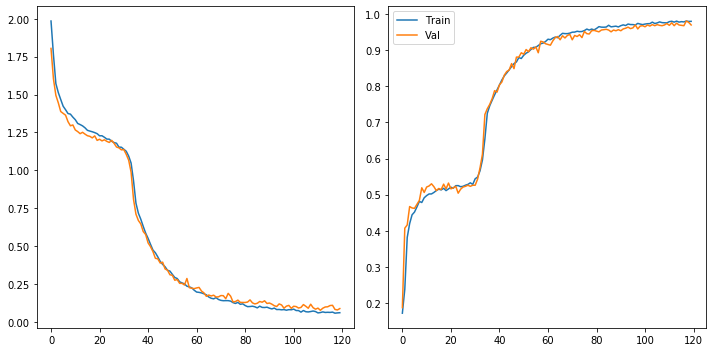

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'], label='Train')
plt.plot(history.epoch, history.history['val_loss'], label='Val')
plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['accuracy'], label='Train')
plt.plot(history.epoch, history.history['val_accuracy'], label='Val')
plt.legend()
plt.tight_layout()